In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [39]:
import matplotlib.font_manager as font_manager

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(context='talk', style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'

pd.set_option('display.max_columns', 60)

In [40]:
df = pd.read_excel("ESW_data_cleaned.xls")
df = df.drop([537, 440, 557, 523, 811, 824, 990], axis=0)
df['zt_plan'] = df['zt_plan'].replace({
    'Yes': 1,
    'No': 2,
    "Don't know yet" : 3
})
df['esw_plan'] = df['esw_plan'].replace({
    'Yes': 1,
    'No': 2,
    "Don't know yet" : 3
})
df = df[df['esw_plan'] != 3]
df = df[df['zt_plan'] != 3]
df['use_esw'] = 2 - df['esw_plan']
df['use_zt'] = 2 - df['zt_plan']
df['use_any'] = df.apply(lambda x: x['use_zt'] == 1 or x['use_esw'] == 1, axis=1)
df.shape

(915, 30)

In [41]:
df['use'] = df.apply(lambda x: 1 if x['zt_use'] == 1 or x['esw_use'] == 1 else 0, axis=1)
print(df['use'].value_counts())
df['plan'] = df.apply(lambda x: 1 if x['zt_plan'] == 1 or x['esw_plan'] == 1 else 0, axis=1)
df['hear'] = df.apply(lambda x: 1 if x['zt_hear'] == 1 or x['esw_hear'] == 1 else 0, axis=1)


df.drop(['zt_use', 'zt_plan', 'esw_plan', 'esw_use', 'use_zt', 'use_esw', 'income_agric', 'zt_hear', 'esw_hear'], axis=1, inplace=True)

correlations = df.copy()


correlations.drop(['vilid'], axis=1, inplace=True)
correlations['child_count'] = correlations['male_child'] + correlations['female_child']
correlations['cost'] = correlations['cost_nonlab'] + correlations['cost_lab']
correlations.drop(['male_child', 'female_child', 'cost_nonlab', 'cost_lab'], axis=1, inplace=True)
correlations['adult_count'] = correlations['male_adult'] + correlations['female_adult']
correlations.drop(['male_adult', 'female_adult'], axis=1, inplace=True)

use
0    681
1    234
Name: count, dtype: int64


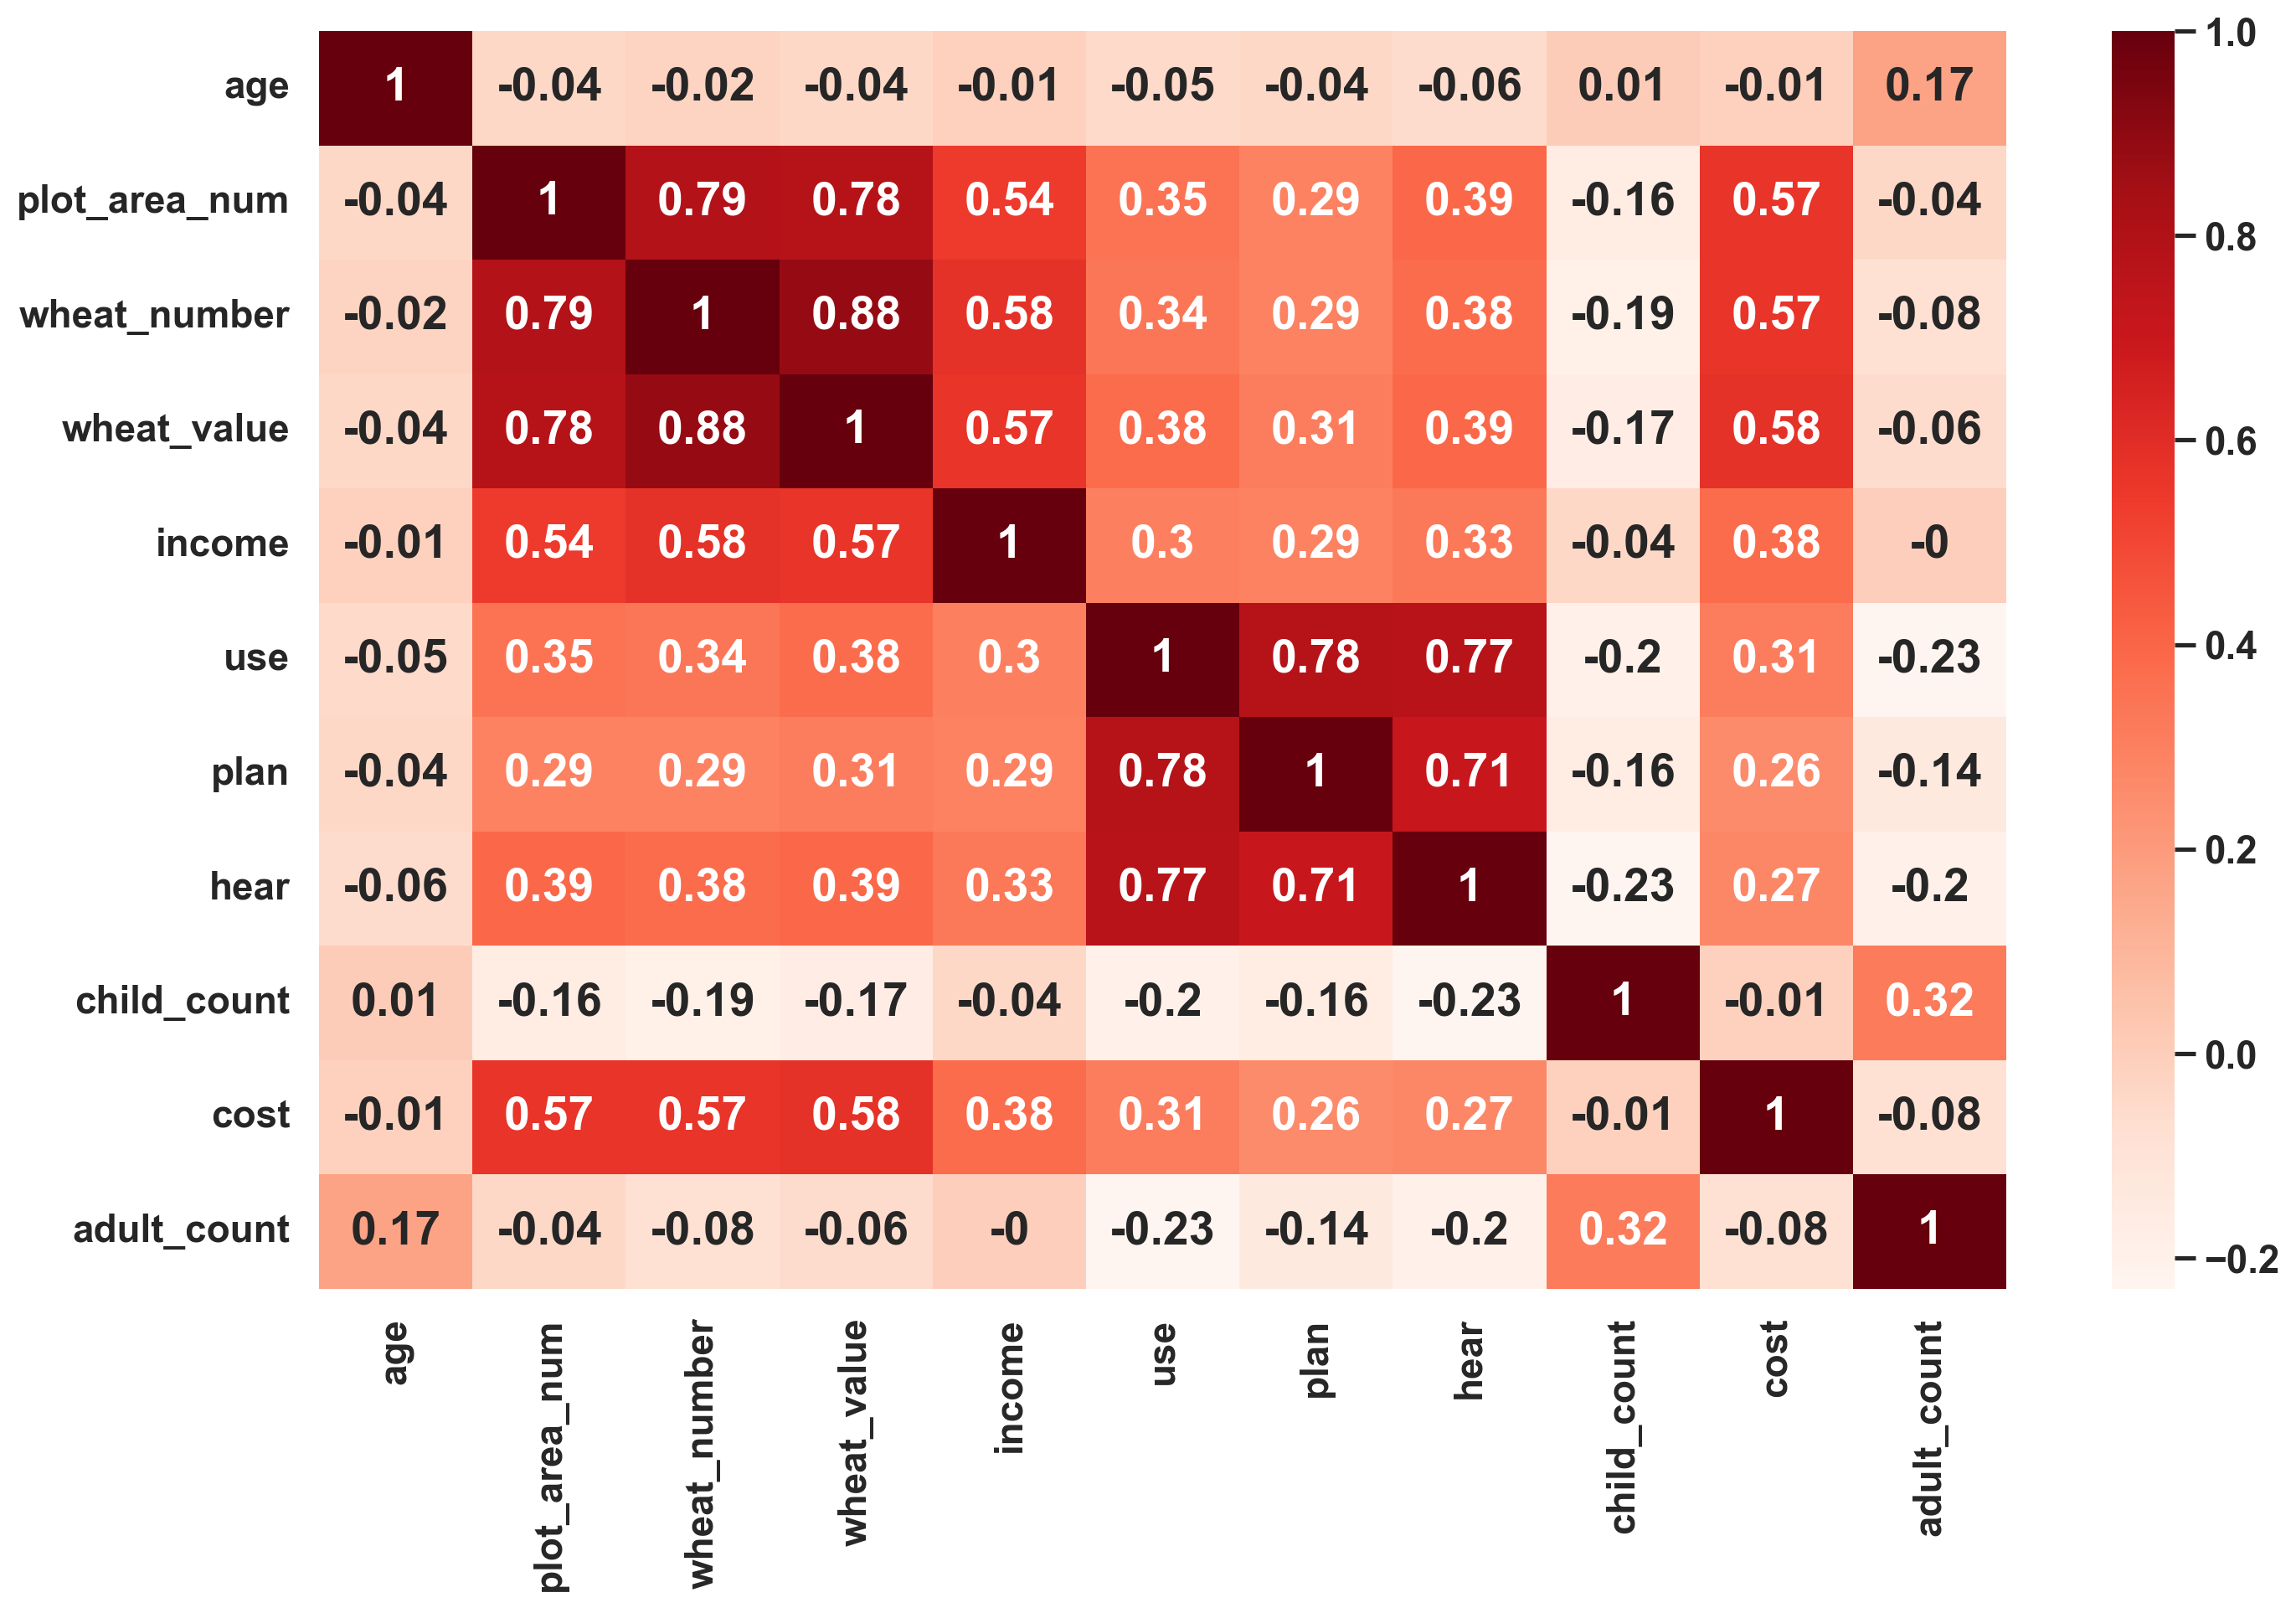

In [42]:
plt.figure(figsize=(15, 10))

sns.heatmap(correlations.select_dtypes(include=np.number).corr(method='spearman').round(2), annot=True, cmap="Reds")

plt.show()

In [3]:
# Создаем бинарные флаги для использования и планирования
df['used_new_method'] = ((df['zt_use'] == 1) | (df['esw_use'] == 1)).astype(int)
df['plan_new_method'] = ((df['zt_plan'] == 1) | (df['esw_plan'] == 1)).astype(int)

# Группируем данные по деревням (vilid)
grouped = df.groupby('vilid')

# Для каждой деревни вычисляем необходимые суммы по всем её жителям
vilid_stats = grouped.agg(
    total_in_village=('hhid', 'count'),
    total_used_in_village=('used_new_method', 'sum'),
    total_plan_in_village=('plan_new_method', 'sum')
).reset_index()

# Мерджим (соединяем) эти общие показатели обратно к исходному DataFrame
df = df.merge(vilid_stats, on='vilid', how='left')

# Вычисляем персональные для каждого человека показатели о его соседях
df['total_neighbors'] = df['total_in_village'] - 1
df['neighbors_used_new_method'] = df['total_used_in_village'] - df['used_new_method']
df['neighbors_plan_new_method'] = df['total_plan_in_village'] - df['plan_new_method']

# Вычисляем долю соседей, использовавших новые методы
df['proportion_neighbors_used'] = df['neighbors_used_new_method'] / df['total_neighbors']
df['proportion_neighbors_used'] = df['proportion_neighbors_used'].fillna(0)

# Удаляем промежуточные столбцы
df = df.drop(['total_in_village', 'total_used_in_village', 'total_plan_in_village'], axis=1)

print("Созданы переменные для анализа влияния соседей:")
print("- total_neighbors: количество соседей в деревне")
print("- neighbors_used_new_method: количество соседей, использовавших новые методы")
print("- proportion_neighbors_used: доля соседей, использовавших новые методы")

Созданы переменные для анализа влияния соседей:
- total_neighbors: количество соседей в деревне
- neighbors_used_new_method: количество соседей, использовавших новые методы
- proportion_neighbors_used: доля соседей, использовавших новые методы


In [4]:
df[(df['plan_new_method'] == 1) & (df['neighbors_used_new_method'] > 0) & (df['used_new_method'] == 0)]

,hhid,vilid,distid,stateid,gender,male_adult,female_adult,male_child,female_child,age,educ,esw_hear,esw_use,esw_plan,zt_hear,zt_use,zt_plan,plot_area_num,wheat_number,wheat_value,cost_nonlab,cost_lab,water,fuel,lighting,income,income_agric,use_esw,use_zt,use_any,used_new_method,plan_new_method,total_neighbors,neighbors_used_new_method,neighbors_plan_new_method,proportion_neighbors_used
21,1202 11,1202,Kurukshetra,Haryana,Male,2,2,1,1,31,Completed university degree,2,NaN,NaN,1,2.0,1.0,2.0,44.000000,86240,30000.0,0.0,Pipeline inside own house,LPG,Solar,NaN,NaN,NaN,1.0,True,0,1,14,2,2,0.142857
22,1202 12,1202,Kurukshetra,Haryana,Female,3,3,1,1,60,No formal education,2,NaN,NaN,1,2.0,1.0,6.0,72.000000,129600,30000.0,12000.0,Pipeline inside own house,LPG,Solar,1000000.0,0.000000,NaN,1.0,True,0,1,14,2,2,0.142857
414,1504 4,1504,Rewari,Haryana,Male,6,3,2,3,57,Some primary education,2,NaN,NaN,1,2.0,1.0,4.5,40.000000,80000,8000.0,8000.0,Pipeline inside own house,LPG,Coal or charcoal,120000.0,75.000000,NaN,1.0,True,0,1,12,1,2,0.083333
419,1504 9,1504,Rewari,Haryana,Male,2,3,2,0,70,Completed primary education,2,NaN,NaN,1,2.0,1.0,1.0,14.000000,30000,8000.0,6000.0,Pipeline inside own house,Wood,Solar,180000.0,10.000000,NaN,1.0,True,0,1,12,1,2,0.083333
460,1507 1,1507,Rewari,Haryana,Male,5,3,1,0,39,Completed university degree,2,NaN,NaN,1,2.0,1.0,2.0,40.000000,80000,5000.0,20000.0,Borewell in residence yard,Wood,Solar,500000.0,100.000000,NaN,1.0,True,0,1,9,1,2,0.111111
469,1507 12,1507,Rewari,Haryana,Male,1,1,0,1,34,Completed secondary education,1,2.0,1.0,2,NaN,NaN,0.5,15.249928,14400,2000.0,4000.0,Pipeline inside own house,Leaves/ grass/ rice husks /stubble /straw,Solar,50000.0,25.000000,1.0,NaN,True,0,1,9,1,2,0.111111
554,2101 13,2101,Amritsar,Punjab,Male,2,1,0,0,25,Some university education,2,NaN,NaN,1,2.0,1.0,3.0,60.000000,180000,30000.0,10000.0,Borewell in residence yard,LPG,Solar,423000.0,0.000000,NaN,1.0,True,0,1,15,8,3,0.533333
577,2103 10,2103,Amritsar,Punjab,Male,3,3,0,0,26,Completed secondary education,2,NaN,NaN,1,2.0,1.0,3355.0,805.000000,1622075,280000.0,1500000.0,Borewell in residence yard,Biogas,Solar,1000000.0,0.000000,NaN,1.0,True,0,1,12,12,12,1.000000
587,2105 7,2105,Amritsar,Punjab,Male,2,2,1,2,65,No formal education,2,NaN,NaN,1,2.0,1.0,4.0,52.000000,545350,4800.0,6000.0,Borewell in residence yard,LPG,Solar,800000.0,0.000000,NaN,1.0,True,0,1,8,6,5,0.750000
609,2107 10,2107,Amritsar,Punjab,Male,2,1,0,0,55,Completed secondary education,2,NaN,NaN,1,2.0,1.0,2.0,36.000000,106200,20000.0,150000.0,Borewell in residence yard,LPG,Solar,79320.0,0.000000,NaN,1.0,True,0,1,7,2,2,0.285714


<Axes: ylabel='proportion_neighbors_used'>

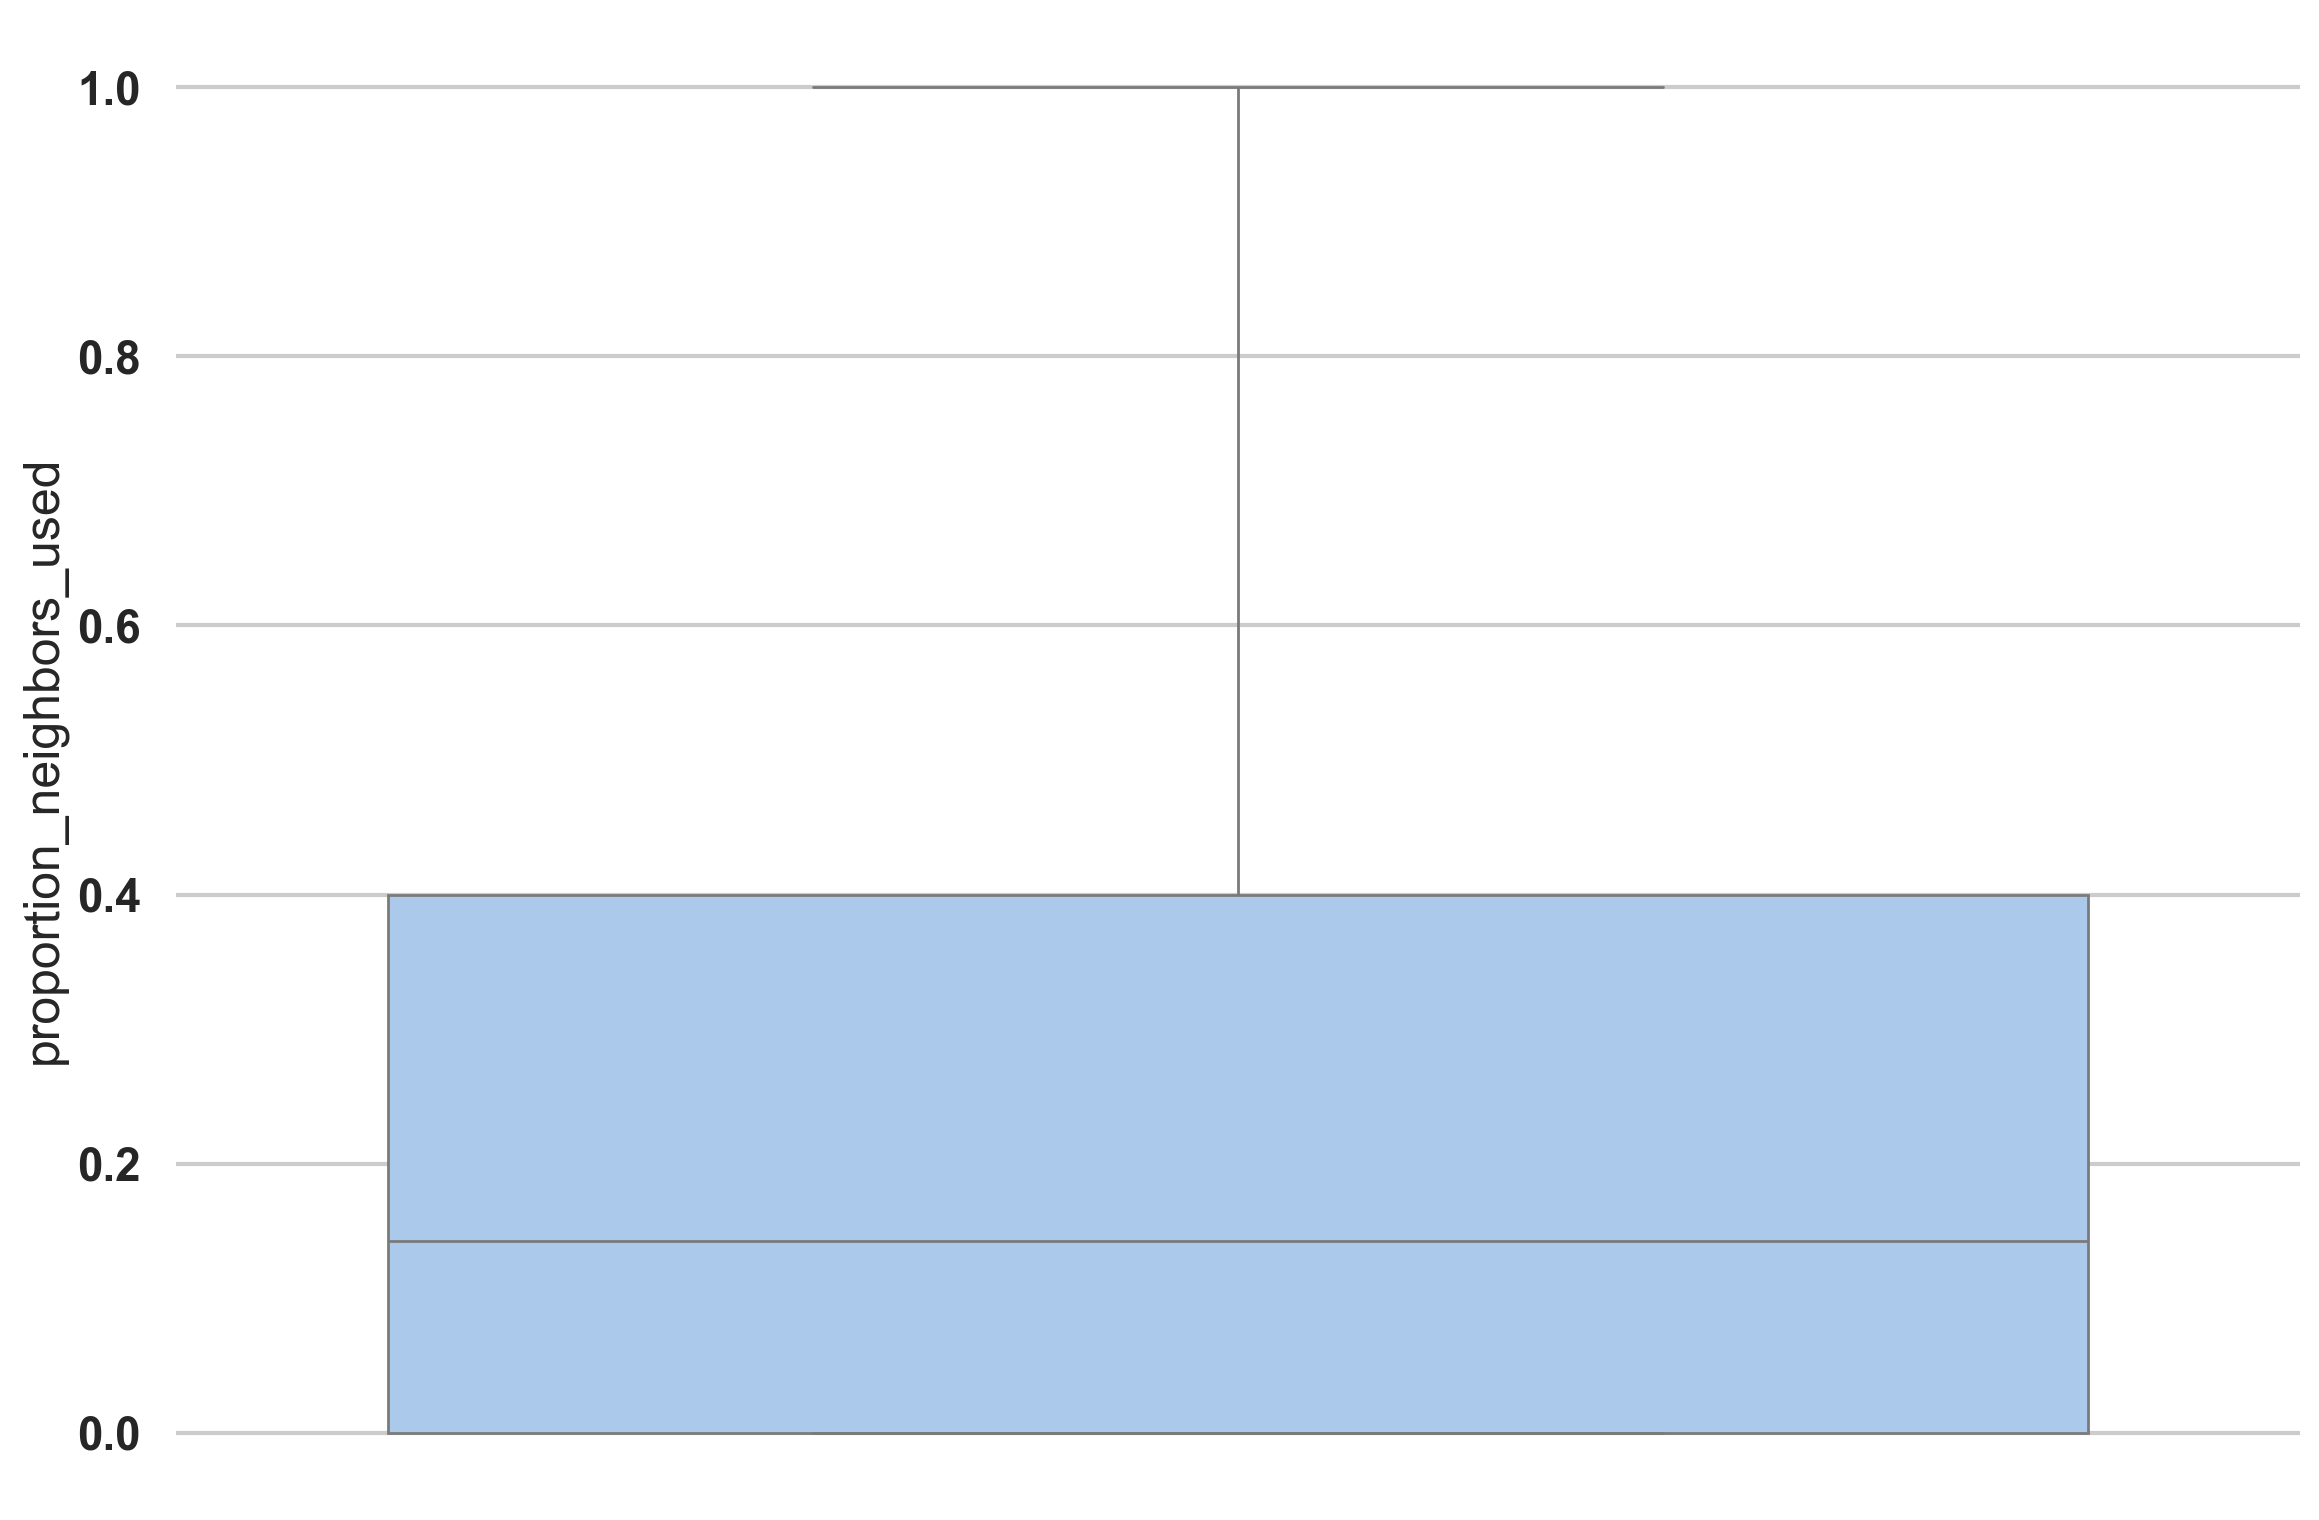

In [5]:
sns.boxplot(df['proportion_neighbors_used'])

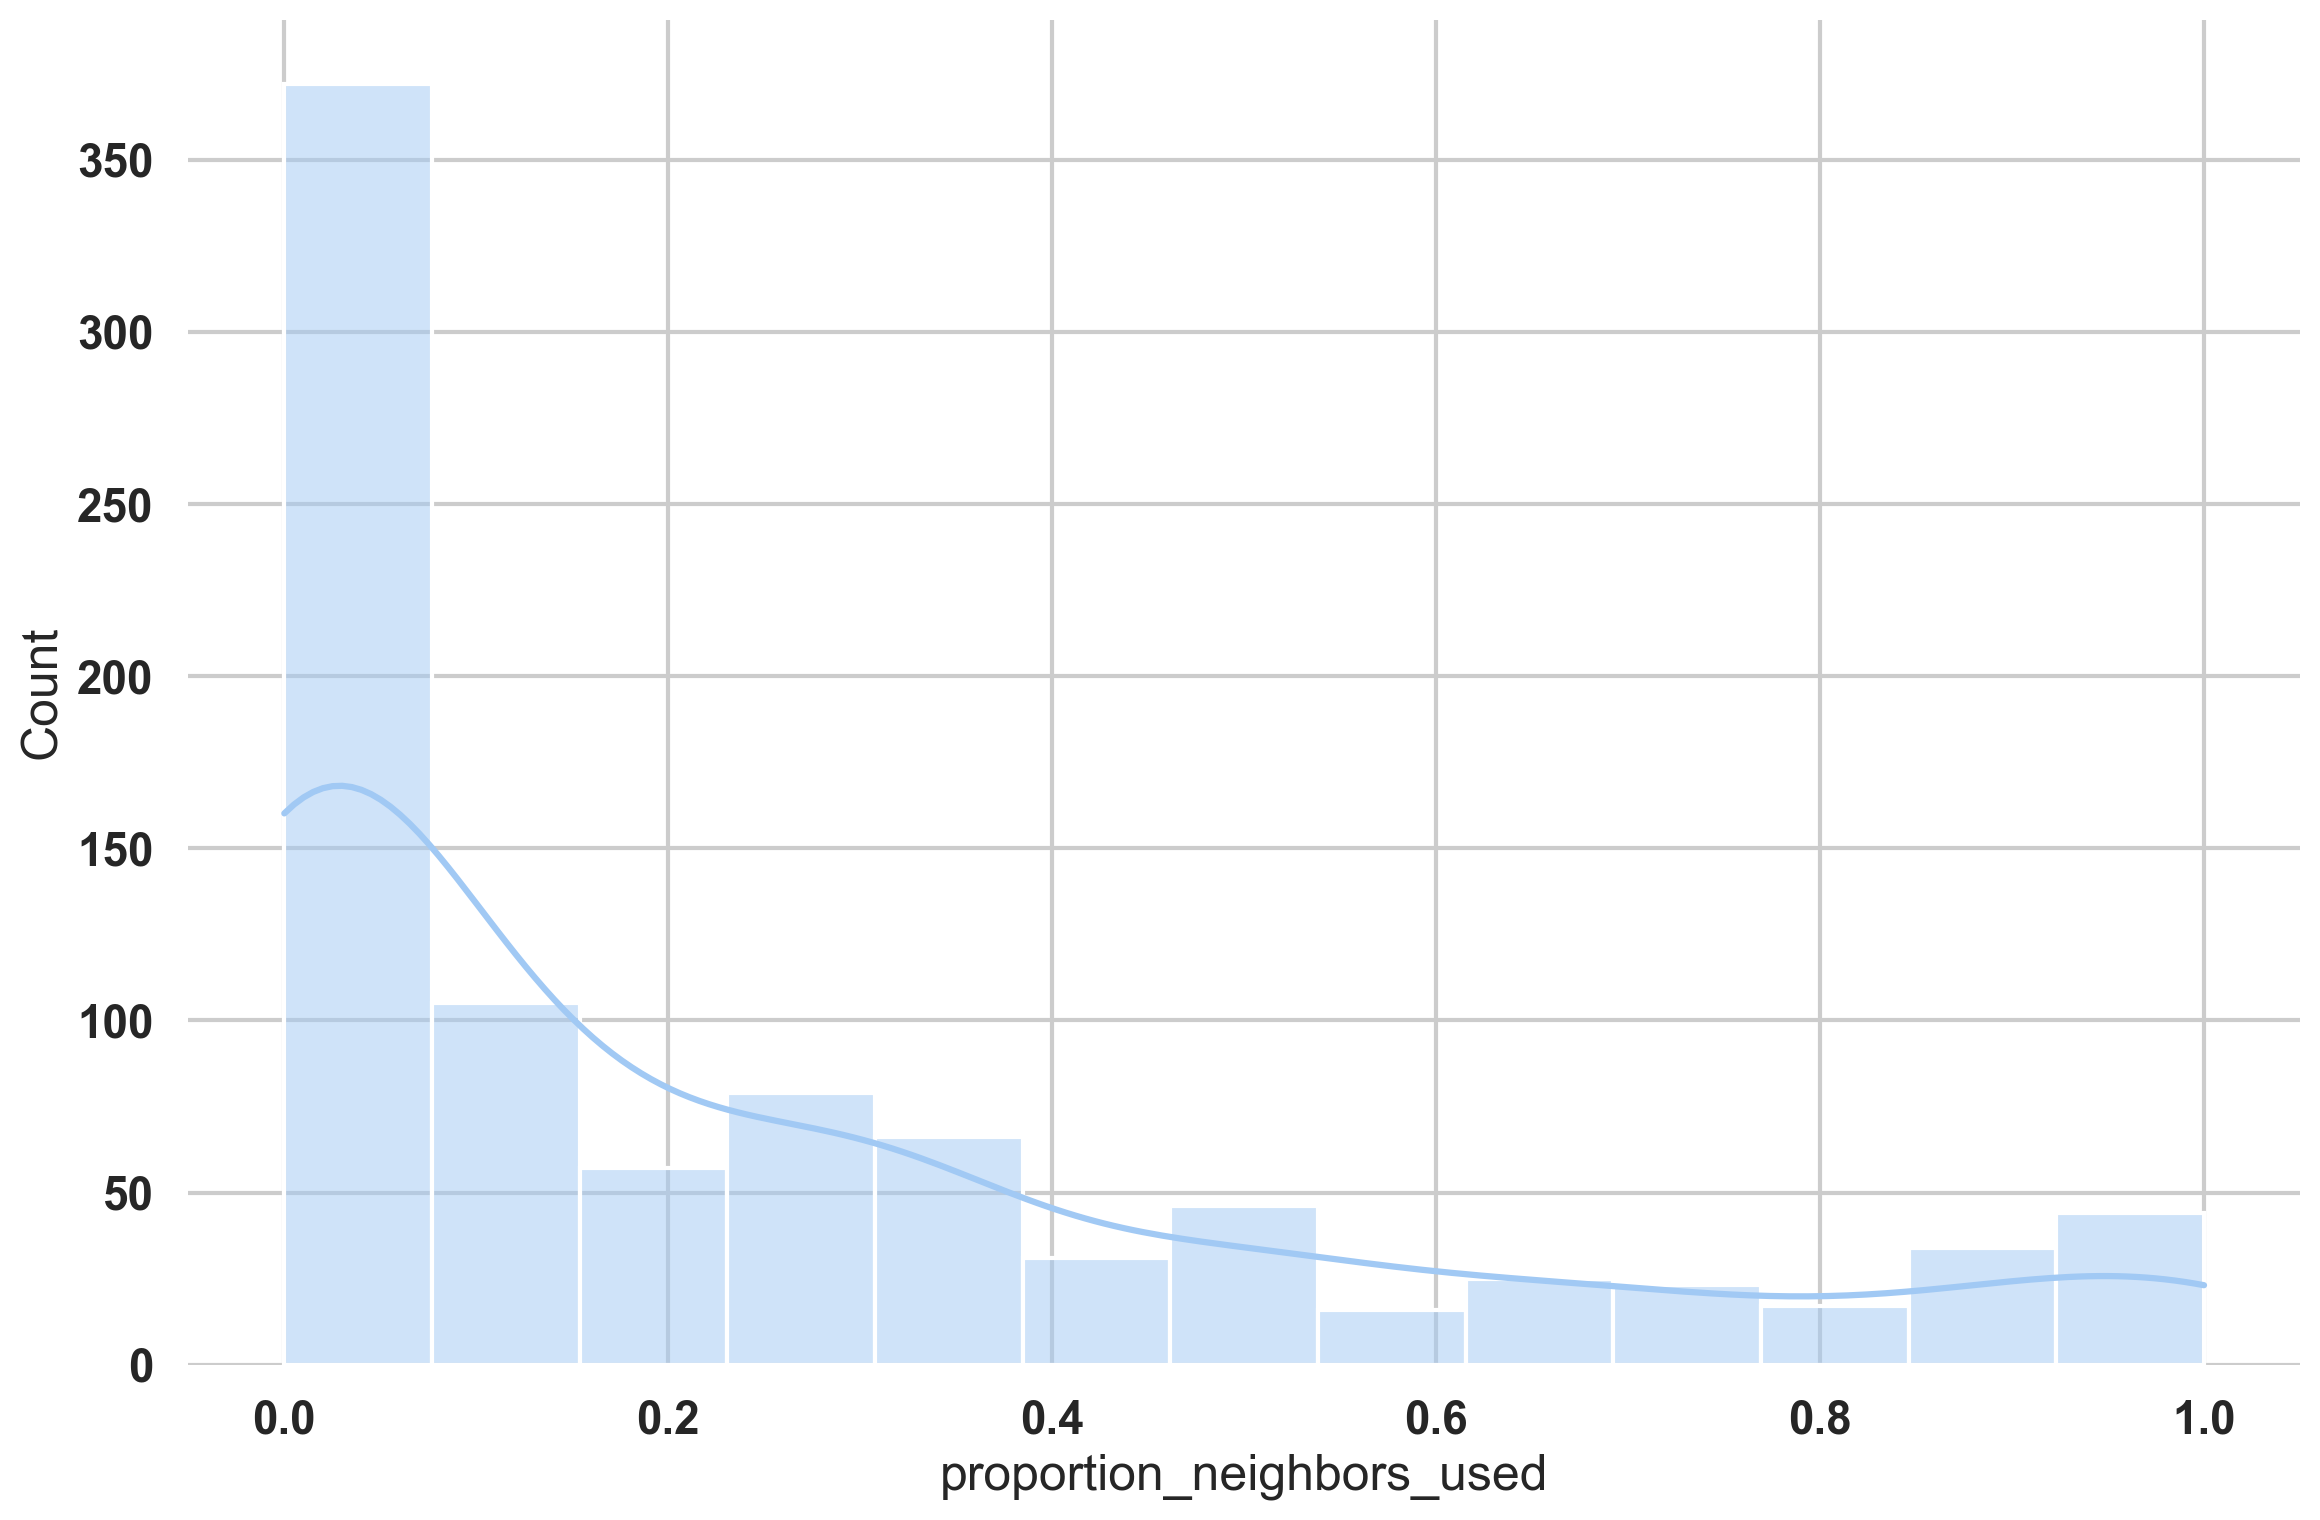

In [6]:
sns.histplot(df["proportion_neighbors_used"], kde=True)
plt.show()

In [7]:
df["proportion_neighbors_used"].std(), df["proportion_neighbors_used"].mean()

(np.float64(0.29977489976704347), np.float64(0.25573770491803277))

In [8]:
# Пятый блок
import statsmodels.api as sm

# Подготовка данных для регрессии
X = df['proportion_neighbors_used']
X = sm.add_constant(X)
y = df['plan_new_method']

# Строим логистическую регрессию
model = sm.Logit(y, X)
result = model.fit()

# Выводим результаты
print("РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print("=" * 50)
print(result.summary())
print("\nКЛЮЧЕВЫЕ ВЫВОДЫ:")
print("=" * 50)
print(f"p-значение для влияния соседей: {result.pvalues[1]:.4f}")

# Проверяем статистическую значимость на уровне α=0.05
alpha = 0.05
if result.pvalues[1] < alpha:
    print("✓ Влияние соседей статистически значимо (p < 0.05)")
    odds_ratio = np.exp(result.params[1])
    print(f"✓ Отношение шансов (Odds Ratio): {odds_ratio:.4f}")
    print(f"✓ Интерпретация: При увеличении доли соседей, использовавших новые методы, на 1 единицу,")
    print(f"  шансы планирования использования новых методов увеличиваются в {odds_ratio:.4f} раз")
else:
    print("✗ Влияние соседей не является статистически значимым (p ≥ 0.05)")

Optimization terminated successfully.
         Current function value: 0.396862
         Iterations 6
РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
                           Logit Regression Results                           
Dep. Variable:        plan_new_method   No. Observations:                  915
Model:                          Logit   Df Residuals:                      913
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:                  0.2540
Time:                        10:25:08   Log-Likelihood:                -363.13
converged:                       True   LL-Null:                       -486.76
Covariance Type:            nonrobust   LLR p-value:                 1.026e-55
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.6636      0

In [9]:
df['educ'].value_counts()# Создаем копию DataFrame для анализа
df_analysis = df.copy()

# Удаляем строки с пропущенными значениями в age и income
df_analysis = df_analysis.dropna(subset=['age', 'income'])

# Создаем категории на основе квантилей
df_analysis['age_group'] = pd.qcut(df_analysis['age'], q=3, labels=['Молодые', 'Средний возраст', 'Старшие'])
df_analysis['income_group'] = pd.qcut(df_analysis['income'], q=3, labels=['Низкий доход', 'Средний доход', 'Высокий доход'])

# Функция для выполнения логистической регрессии
def run_logistic_regression(data, group_name):
    X = data['proportion_neighbors_used']
    X = sm.add_constant(X)
    y = data['plan_new_method']
    
    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=0)
        
        # Рассчитываем псевдо-R^2 (McFadden's R-squared)
        null_model = sm.Logit(y, np.ones_like(y)).fit(disp=0)
        pseudo_r2 = 1 - (result.llf / null_model.llf)
        
        return {
            'Группа': group_name,
            'Наблюдения': len(data),
            'Коэффициент': result.params[1],
            'P-значение': result.pvalues[1],
            'Константа': result.params[0],
            'Псевдо-R2': pseudo_r2,
            'Значим (p<0.05)': result.pvalues[1] < 0.05,
            'Доверительный интервал (нижний)': result.conf_int().iloc[1, 0],
            'Доверительный интервал (верхний)': result.conf_int().iloc[1, 1]
        }
    except Exception as e:
        print(f"Ошибка при построении модели для группы {group_name}: {e}")
        return None

# Проводим анализ для различных подгрупп
results = []

# 1. Полная выборка
results.append(run_logistic_regression(df_analysis, "Полная выборка"))

# 2. По возрастным группам
for age_group in df_analysis['age_group'].unique():
    subset = df_analysis[df_analysis['age_group'] == age_group]
    result = run_logistic_regression(subset, f"Возраст: {age_group}")
    if result:
        results.append(result)

# 3. По группам дохода
for income_group in df_analysis['income_group'].unique():
    subset = df_analysis[df_analysis['income_group'] == income_group]
    result = run_logistic_regression(subset, f"Доход: {income_group}")
    if result:
        results.append(result)

# 4. По уровню образования (educ)
# Сначала удаляем пропущенные значения в education
df_education = df_analysis.dropna(subset=['educ'])
for educ_level in df_education['educ'].unique():
    subset = df_education[df_education['educ'] == educ_level]
    if len(subset) > 30:  # Ensure sufficient observations
        result = run_logistic_regression(subset, f"Образование: {educ_level}")
        if result:
            results.append(result)

# 5. По источнику воды (water)
# Сначала удаляем пропущенные значения в water
df_water = df_analysis.dropna(subset=['water'])
for water_source in df_water['water'].unique():
    subset = df_water[df_water['water'] == water_source]
    if len(subset) > 30:  # Ensure sufficient observations
        # Сокращаем длинные названия для лучшей читаемости
        water_short = water_source[:30] + "..." if len(water_source) > 30 else water_source
        result = run_logistic_regression(subset, f"Вода: {water_short}")
        if result:
            results.append(result)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# Выводим таблицу результатов
print("АНАЛИЗ УСТОЙЧИВОСТИ ПО ДЕМОГРАФИЧЕСКИМ ГРУППАМ И КАТЕГОРИЯМ")
print("=" * 90)
for _, row in results_df.iterrows():
    significance = "✓ Значимо" if row['Значим (p<0.05)'] else "✗ Не значимо"
    print(f"{row['Группа']}:")
    print(f"  {significance} (p={row['P-значение']:.4f})")
    print(f"  Коэффициент: {row['Коэффициент']:.4f}")
    print(f"  Константа: {row['Константа']:.4f}")
    print(f"  Псевдо-R2: {row['Псевдо-R2']:.4f}")
    print(f"  Наблюдения: {row['Наблюдения']}")
    print(f"  ДИ: [{row['Доверительный интервал (нижний)']:.4f}, {row['Доверительный интервал (верхний)']:.4f}]")
    print()

# Анализ устойчивости: проверяем, насколько результаты согласуются между группами
print("\nАНАЛИЗ УСТОЙЧИВОСТИ РЕЗУЛЬТАТОВ")
print("=" * 50)

# Подсчитываем, в скольких группах эффект значим
significant_groups = sum(results_df['Значим (p<0.05)'])
total_groups = len(results_df)
significance_ratio = significant_groups / total_groups

print(f"Эффект значим в {significant_groups} из {total_groups} групп ({significance_ratio:.2%})")

if significance_ratio >= 0.7:
    print("✓ Результаты демонстрируют высокую устойчивость")
elif significance_ratio >= 0.5:
    print("➖ Результаты умеренно устойчивы")
else:
    print("✗ Результаты не демонстрируют устойчивости")

# Анализ согласованности направленности эффекта
positive_effects = sum(results_df['Коэффициент'] > 0)
negative_effects = sum(results_df['Коэффициент'] < 0)

print(f"\nНаправленность эффекта:")
print(f"  Положительный эффект: {positive_effects} групп")
print(f"  Отрицательный эффект: {negative_effects} групп")

if positive_effects > negative_effects * 2:
    print("✓ Преобладает положительный эффект влияния соседей")
elif negative_effects > positive_effects * 2:
    print("✗ Преобладает отрицательный эффект влияния соседей")
else:
    print("➖ Направленность эффекта неоднозначна")

АНАЛИЗ УСТОЙЧИВОСТИ ПО ДЕМОГРАФИЧЕСКИМ ГРУППАМ И КАТЕГОРИЯМ
Полная выборка:
  ✓ Значимо (p=0.0000)
  Коэффициент: 4.3098
  Константа: -2.7668
  Псевдо-R2: 0.2315
  Наблюдения: 758
  ДИ: [3.5771, 5.0425]

Возраст: Молодые:
  ✓ Значимо (p=0.0000)
  Коэффициент: 3.8450
  Константа: -2.5308
  Псевдо-R2: 0.2102
  Наблюдения: 253
  ДИ: [2.7326, 4.9573]

Возраст: Старшие:
  ✓ Значимо (p=0.0000)
  Коэффициент: 6.0300
  Константа: -3.1031
  Псевдо-R2: 0.3537
  Наблюдения: 238
  ДИ: [4.3837, 7.6763]

Возраст: Средний возраст:
  ✓ Значимо (p=0.0000)
  Коэффициент: 3.4726
  Константа: -2.7438
  Псевдо-R2: 0.1435
  Наблюдения: 267
  ДИ: [2.2049, 4.7402]

Доход: Низкий доход:
  ✓ Значимо (p=0.0002)
  Коэффициент: 3.1667
  Константа: -2.9867
  Псевдо-R2: 0.0766
  Наблюдения: 289
  ДИ: [1.5147, 4.8187]

Доход: Высокий доход:
  ✓ Значимо (p=0.0000)
  Коэффициент: 3.8949
  Константа: -2.1069
  Псевдо-R2: 0.2207
  Наблюдения: 249
  ДИ: [2.8555, 4.9342]

Доход: Средний доход:
  ✓ Значимо (p=0.0000)
  Коэф

In [10]:
results_df

,Группа,Наблюдения,Коэффициент,P-значение,Константа,Псевдо-R2,Значим (p<0.05),Доверительный интервал (нижний),Доверительный интервал (верхний)
0,Полная выборка,758,4.309791,9.517545e-31,-2.766839,0.231485,True,3.577059,5.042523
1,Возраст: Молодые,253,3.844976,1.245766e-11,-2.530791,0.210170,True,2.732616,4.957335
2,Возраст: Старшие,238,6.030020,7.022949e-13,-3.103091,0.353720,True,4.383740,7.676300
3,Возраст: Средний возраст,267,3.472590,7.911718e-08,-2.743822,0.143496,True,2.204945,4.740235
4,Доход: Низкий доход,289,3.166692,1.718817e-04,-2.986670,0.076610,True,1.514734,4.818651
5,Доход: Высокий доход,249,3.894865,2.059003e-13,-2.106949,0.220673,True,2.855533,4.934197
6,Доход: Средний доход,220,4.227773,1.318510e-07,-3.027458,0.196386,True,2.657287,5.798259
7,Образование: Completed secondary education,206,3.722885,4.100101e-08,-2.549009,0.180801,True,2.392940,5.052829
8,Образование: No formal education,115,3.544400,4.576382e-04,-2.640374,0.129868,True,1.562064,5.526735
9,Образование: Completed primary education,125,5.603123,1.436104e-07,-3.182595,0.341347,True,3.515531,7.690714


In [11]:
# Подготовка данных для множественной логистической регрессии
X_lr = df[['proportion_neighbors_used', 'age', 'educ', 'income', 'plot_area_num', 'cost_nonlab']].copy()
y_lr = df['plan_new_method'].copy()

# Преобразуем категориальные переменные в числовые (если они есть)
for col in X_lr.columns:
    if X_lr[col].dtype == 'object':
        X_lr[col] = pd.factorize(X_lr[col])[0]  # Преобразуем категории в числа

# Удаляем пропущенные значения
data_for_regression = pd.concat([X_lr, y_lr], axis=1).dropna()
X_lr_clean = data_for_regression[['proportion_neighbors_used', 'age', 'educ', 'income', 'plot_area_num', 'cost_nonlab']]
y_lr_clean = data_for_regression['plan_new_method']

# Добавляем константу
X_lr_clean = sm.add_constant(X_lr_clean)

# Строим множественную логистическую регрессию
multi_model = sm.Logit(y_lr_clean, X_lr_clean)
multi_result = multi_model.fit()

# Рассчитываем псевдо-R^2 (McFadden's R-squared)
null_model = sm.Logit(y_lr_clean, np.ones(len(y_lr_clean))).fit(disp=0)
pseudo_r2 = 1 - (multi_result.llf / null_model.llf)

# Выводим результаты
print("МНОЖЕСТВЕННАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)
print(multi_result.summary())
print("\nДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ:")
print(f"Псевдо-R2 (McFadden): {pseudo_r2:.4f}")

# Анализ значимости переменных
print("\nСТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ПЕРЕМЕННЫХ (α=0.05):")
print("=" * 60)
for i, var in enumerate(X_lr_clean.columns):
    if var != 'const':  # Пропускаем константу
        p_value = multi_result.pvalues[i]
        coef = multi_result.params[i]
        significance = "✓ Значимо" if p_value < 0.05 else "✗ Не значимо"
        print(f"{var}: {significance} (p={p_value:.4f}, коэф={coef:.4f})")

# Интерпретация коэффициента основной переменной
neighbors_coef = multi_result.params['proportion_neighbors_used']
neighbors_p = multi_result.pvalues['proportion_neighbors_used']
if neighbors_p < 0.05:
    odds_ratio = np.exp(neighbors_coef)
    print(f"\nИНТЕРПРЕТАЦИЯ ОСНОВНОЙ ПЕРЕМЕННОЙ:")
    print(f"При контроле всех других факторов, увеличение доли соседей на 1 единицу")
    print(f"увеличивает шансы планирования использования новых методов в {odds_ratio:.4f} раз")
else:
    print(f"\nОсновная переменная (proportion_neighbors_used) не является статистически значимой")
    print(f"при контроле других факторов (p={neighbors_p:.4f})")

Optimization terminated successfully.
         Current function value: 0.358064
         Iterations 10
МНОЖЕСТВЕННАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
                           Logit Regression Results                           
Dep. Variable:        plan_new_method   No. Observations:                  758
Model:                          Logit   Df Residuals:                      751
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:                  0.2576
Time:                        10:25:08   Log-Likelihood:                -271.41
converged:                       True   LL-Null:                       -365.61
Covariance Type:            nonrobust   LLR p-value:                 5.581e-38
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.3778   

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import statsmodels.api as sm

# 1. Подготовка данных: удаляем строки с NaN
X_lr = df[['proportion_neighbors_used', 'age', 'educ', 'income', 'plot_area_num', 'cost_nonlab']].copy().dropna()
y_lr = df.loc[X_lr.index, 'plan_new_method'].copy()

# 2. Кодируем 'educ' в числа с помощью OrdinalEncoder (если есть порядок)
X_lr = pd.get_dummies(X_lr, columns=['educ'], prefix='educ', drop_first=True)

# 3. Нормализация (стандартизация) признаков
scaler = StandardScaler()
X_lr_scaled = scaler.fit_transform(X_lr)
X_lr_scaled = pd.DataFrame(X_lr_scaled, columns=X_lr.columns, index=X_lr.index)

# 4. Добавляем константу для statsmodels
X_lr_scaled = sm.add_constant(X_lr_scaled)

# 5. Логистическая регрессия с L1-регуляризацией
logit_model = sm.Logit(y_lr, X_lr_scaled)
alpha = 0.1  # можно подбирать
result = logit_model.fit_regularized(method='l1', alpha=alpha, disp=False)

# 6. Feature Importance
coefs = result.params
feature_importance = coefs.drop('const').abs()
feature_importance_norm = feature_importance / feature_importance.sum()

print("\nНормированная важность признаков:")
print(feature_importance_norm)


Нормированная важность признаков:
proportion_neighbors_used             0.478431
age                                   0.006594
income                                0.128687
plot_area_num                         0.044835
cost_nonlab                           0.127177
educ_Completed secondary education    0.025906
educ_Completed university degree      0.018462
educ_No formal education              0.008573
educ_Some primary education           0.074654
educ_Some secondary education         0.040233
educ_Some university education        0.046448
dtype: float64



Нормированная важность признаков:
Доля соседей, использующих метод    0.478431
Возраст                             0.006594
Доход                               0.128687
Площадь участка                     0.044835
Затраты (не на труд)                0.127177
Законченное среднее                 0.025906
Законченное высшее                  0.018462
Нет информации об образовании       0.008573
Незаконченное начальное             0.074654
Незаконченное среднее               0.040233
Незаконченное высшее                0.046448
dtype: float64


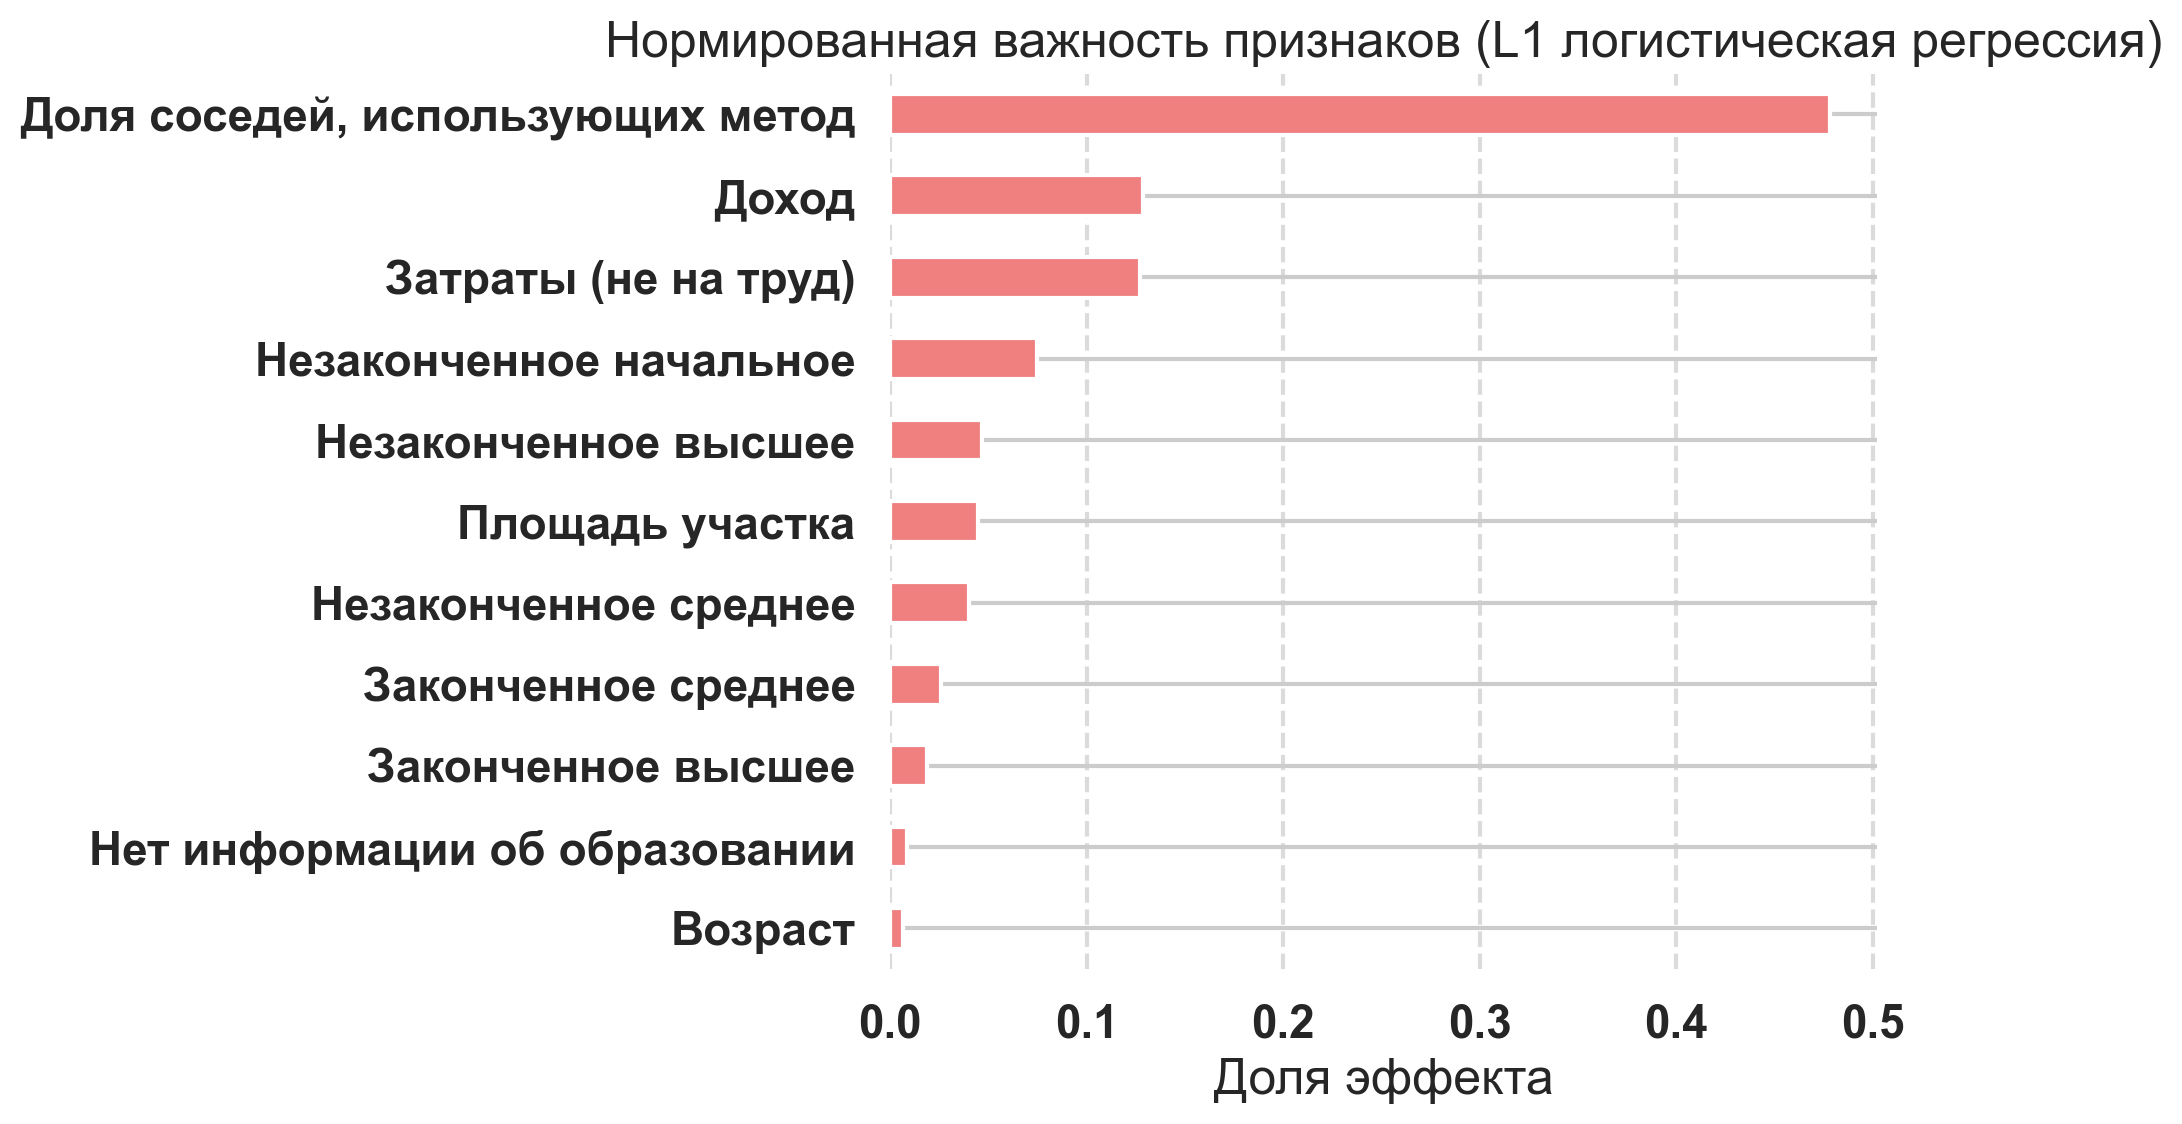

In [15]:
# Создайте словарь для переименования
feature_names_map = {
    'proportion_neighbors_used': 'Доля соседей, использующих метод',
    'age': 'Возраст',
    'income': 'Доход',
    'plot_area_num': 'Площадь участка',
    'cost_nonlab': 'Затраты (не на труд)',
    'educ_Completed secondary education': 'Законченное среднее',
    'educ_Completed university degree': 'Законченное высшее',
    'educ_No formal education': 'Нет информации об образовании',
    'educ_Some primary education': 'Незаконченное начальное',
    'educ_Some university education': 'Незаконченное высшее', 
    'educ_Some secondary education': 'Незаконченное среднее', 
}

# Переименуйте индексы в feature_importance_norm
feature_importance_norm = feature_importance_norm.rename(index=feature_names_map)

# Теперь вывод и график будут с красивыми названиями
print("\nНормированная важность признаков:")
print(feature_importance_norm)

# Визуализация
plt.figure(figsize=(10, 6))
feature_importance_norm.sort_values().plot(kind='barh', color='lightcoral')
plt.title('Нормированная важность признаков (L1 логистическая регрессия)')
plt.xlabel('Доля эффекта')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()  # чтобы длинные названия не обрезались
plt.show()